In [2]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import mapping

from unseen import fileio
from unseen import eva

In [3]:
def get_aus_shape():
    """Get shape for Australia"""
    
    aus_shape = gpd.read_file(
#        '/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/australia/australia.shp',
        '/Users/irv033/Documents/code/shapefiles/data/australia/shapefiles_australia/australia.shp',
        crs="epsg:4326"
    )

    return aus_shape


def clip_data(data, shape):
    """Clip data"""

    data_prep = (
        data
        .rio.write_crs(4326, inplace=True)
        .rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        .rio.write_coordinate_system(inplace=True)
    )
    data_clipped = data_prep.rio.clip(
        shape.geometry.apply(mapping),
        shape.crs,
        drop=False
    )
    
    return data_clipped

In [4]:
shape = get_aus_shape()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


In [5]:
txx_obs_file = '/Users/irv033/Desktop/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'
ds_obs = fileio.open_dataset(txx_obs_file)
da_obs = clip_data(ds_obs['tasmax'], shape)

In [6]:
gev_obs = eva.fit_gev(da_obs)
gev_obs = gev_obs.compute()

In [7]:
txx_model_file = '/Users/irv033/Desktop/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'
ds_model = fileio.open_dataset(txx_model_file)
ds_model_stacked = ds_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})
da_model = clip_data(ds_model_stacked['tasmax'], shape)

In [8]:
gev_model = eva.fit_gev(da_model, core_dim='sample')
gev_model = gev_model.compute()

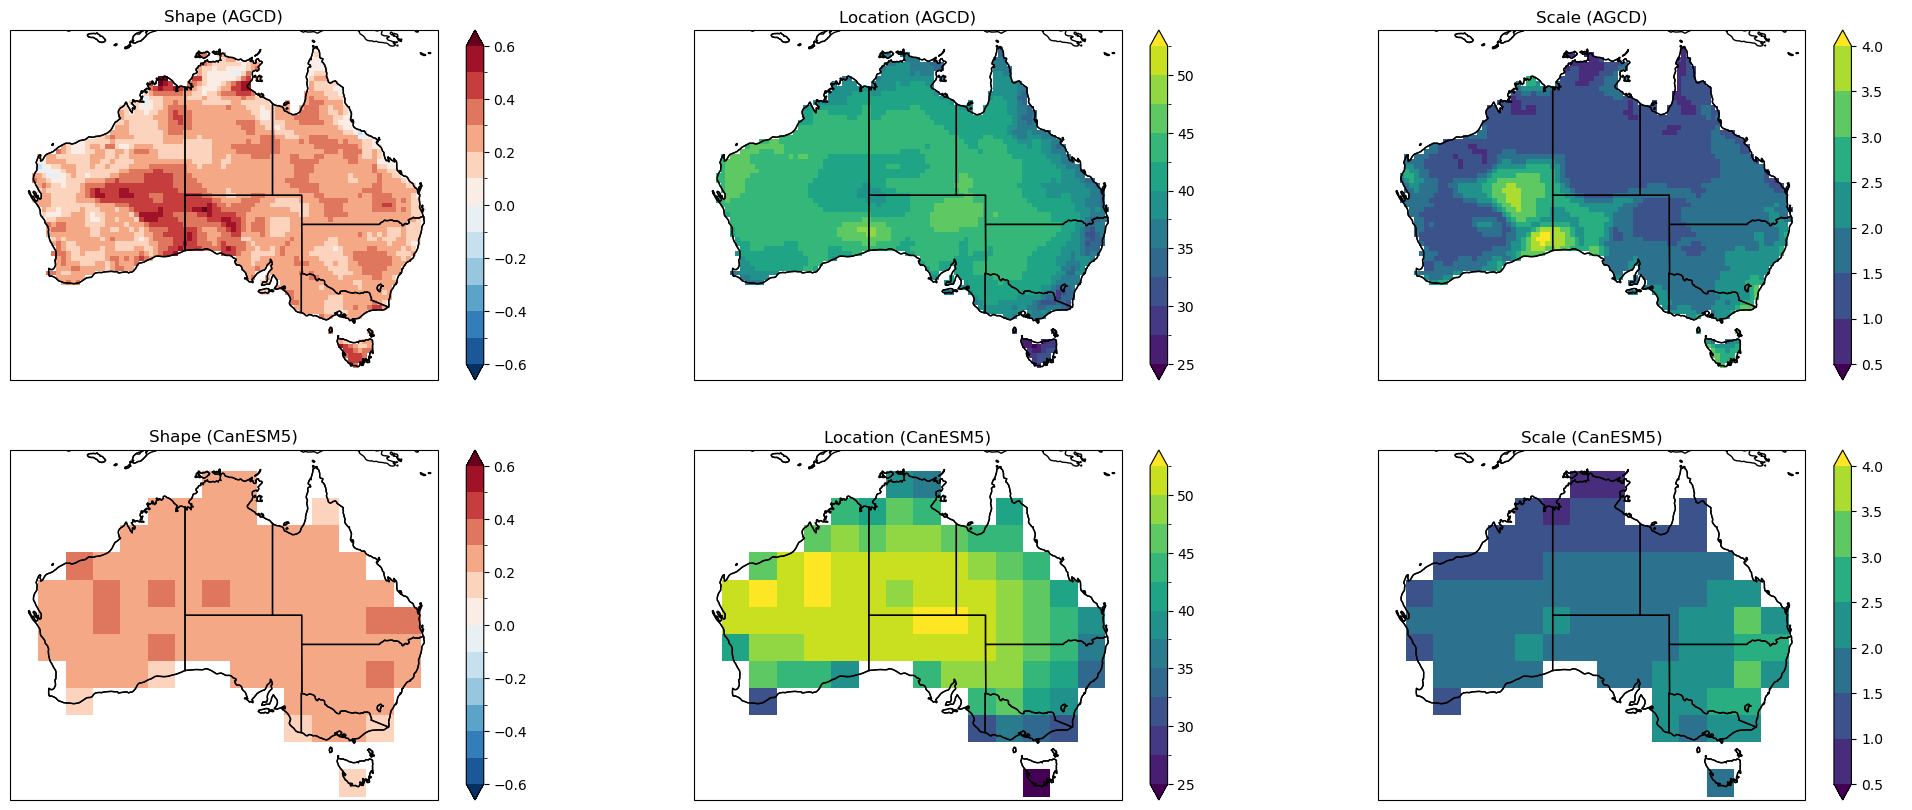

In [13]:
fig = plt.figure(figsize=[25, 10])
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(232, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree())
ax5 = fig.add_subplot(235, projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree())

shape_levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
shape_cmap = 'RdBu_r'
loc_levels = [25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5]
loc_cmap = 'viridis'
scale_levels = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.0]
scale_cmap = 'viridis'

map_extent = [111, 155, -9, -45]

# AGCD

im1 = gev_obs.sel({'dparams': 'c'}).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=shape_cmap,
    levels=shape_levels,
    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax1.set_title("Shape (AGCD)")
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
ax1.set_extent(map_extent, crs=ccrs.PlateCarree())

im2 = gev_obs.sel({'dparams': 'loc'}).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=loc_cmap,
    levels=loc_levels,
    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax2.set_title("Location (AGCD)")
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
ax2.set_extent(map_extent, crs=ccrs.PlateCarree())

im3 = gev_obs.sel({'dparams': 'scale'}).plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=scale_cmap,
    levels=scale_levels,
    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax3.set_title("Scale (AGCD)")
ax3.coastlines()
ax3.add_feature(cartopy.feature.STATES)
ax3.set_extent(map_extent, crs=ccrs.PlateCarree())

# Model

im4 = gev_model.sel({'dparams': 'c'}).plot(
    ax=ax4,
    transform=ccrs.PlateCarree(),
    cmap=shape_cmap,
    levels=shape_levels,
    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax4.set_title("Shape (CanESM5)")
ax4.coastlines()
ax4.add_feature(cartopy.feature.STATES)
ax4.set_extent(map_extent, crs=ccrs.PlateCarree())

im5 = gev_model.sel({'dparams': 'loc'}).plot(
    ax=ax5,
    transform=ccrs.PlateCarree(),
    cmap=loc_cmap,
    levels=loc_levels,
    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax5.set_title("Location (CanESM5)")
ax5.coastlines()
ax5.add_feature(cartopy.feature.STATES)
ax5.set_extent(map_extent, crs=ccrs.PlateCarree())

im6 = gev_model.sel({'dparams': 'scale'}).plot(
    ax=ax6,
    transform=ccrs.PlateCarree(),
    cmap=scale_cmap,
    levels=scale_levels,
    extend='both',
#    add_colorbar=False,
    cbar_kwargs={'label': ' '},
)
ax6.set_title("Scale (CanESM5)")
ax6.coastlines()
ax6.add_feature(cartopy.feature.STATES)
ax6.set_extent(map_extent, crs=ccrs.PlateCarree())

plt.show()